# Sections

- <a href="#1.-Preprocessing"> Preprocessing </a><br>
    - <a href="#Basic-EDA"> Basic Exploratory Data Analysis</a><br>
    - <a href="#SMOTE"> SMOTE (Oversampling) </a><br>
    - <a href="#Data-Wrangling"> Data Wrangling</a><br>
- <a href="#Modeling"> Modeling</a><br>
    - <a href="#KNN-Classifier"> K-Nearest-Neighbors Classifier</a><br>
    - <a href="#Random-Forest"> Random Forest Classifier</a><br>
    - <a href="#Linear-SVC"> Linear Support Vector Classifier</a><br>
    
    
- <a href="#Name-of-Section-Here"> Link Label Text</a><br>

# Preprocessing

In [1]:
# installing data wrangling + plotting modules
import numpy as np
import pandas as pd

%matplotlib inline 
from matplotlib import pyplot as plt 
import seaborn as sns

wine = pd.read_csv('winequality-red.csv') # load dataset

# transform the ordinal-scaled quality variable (1-10, 10 being highest quality)
# target will become:
    # rating >= 7   ---> 'yes'
    # rating < 7    ---> 'no'

wine['quality'] = ['yes' if row >= 7 else 'no' for row in wine['quality']]

## Basic EDA

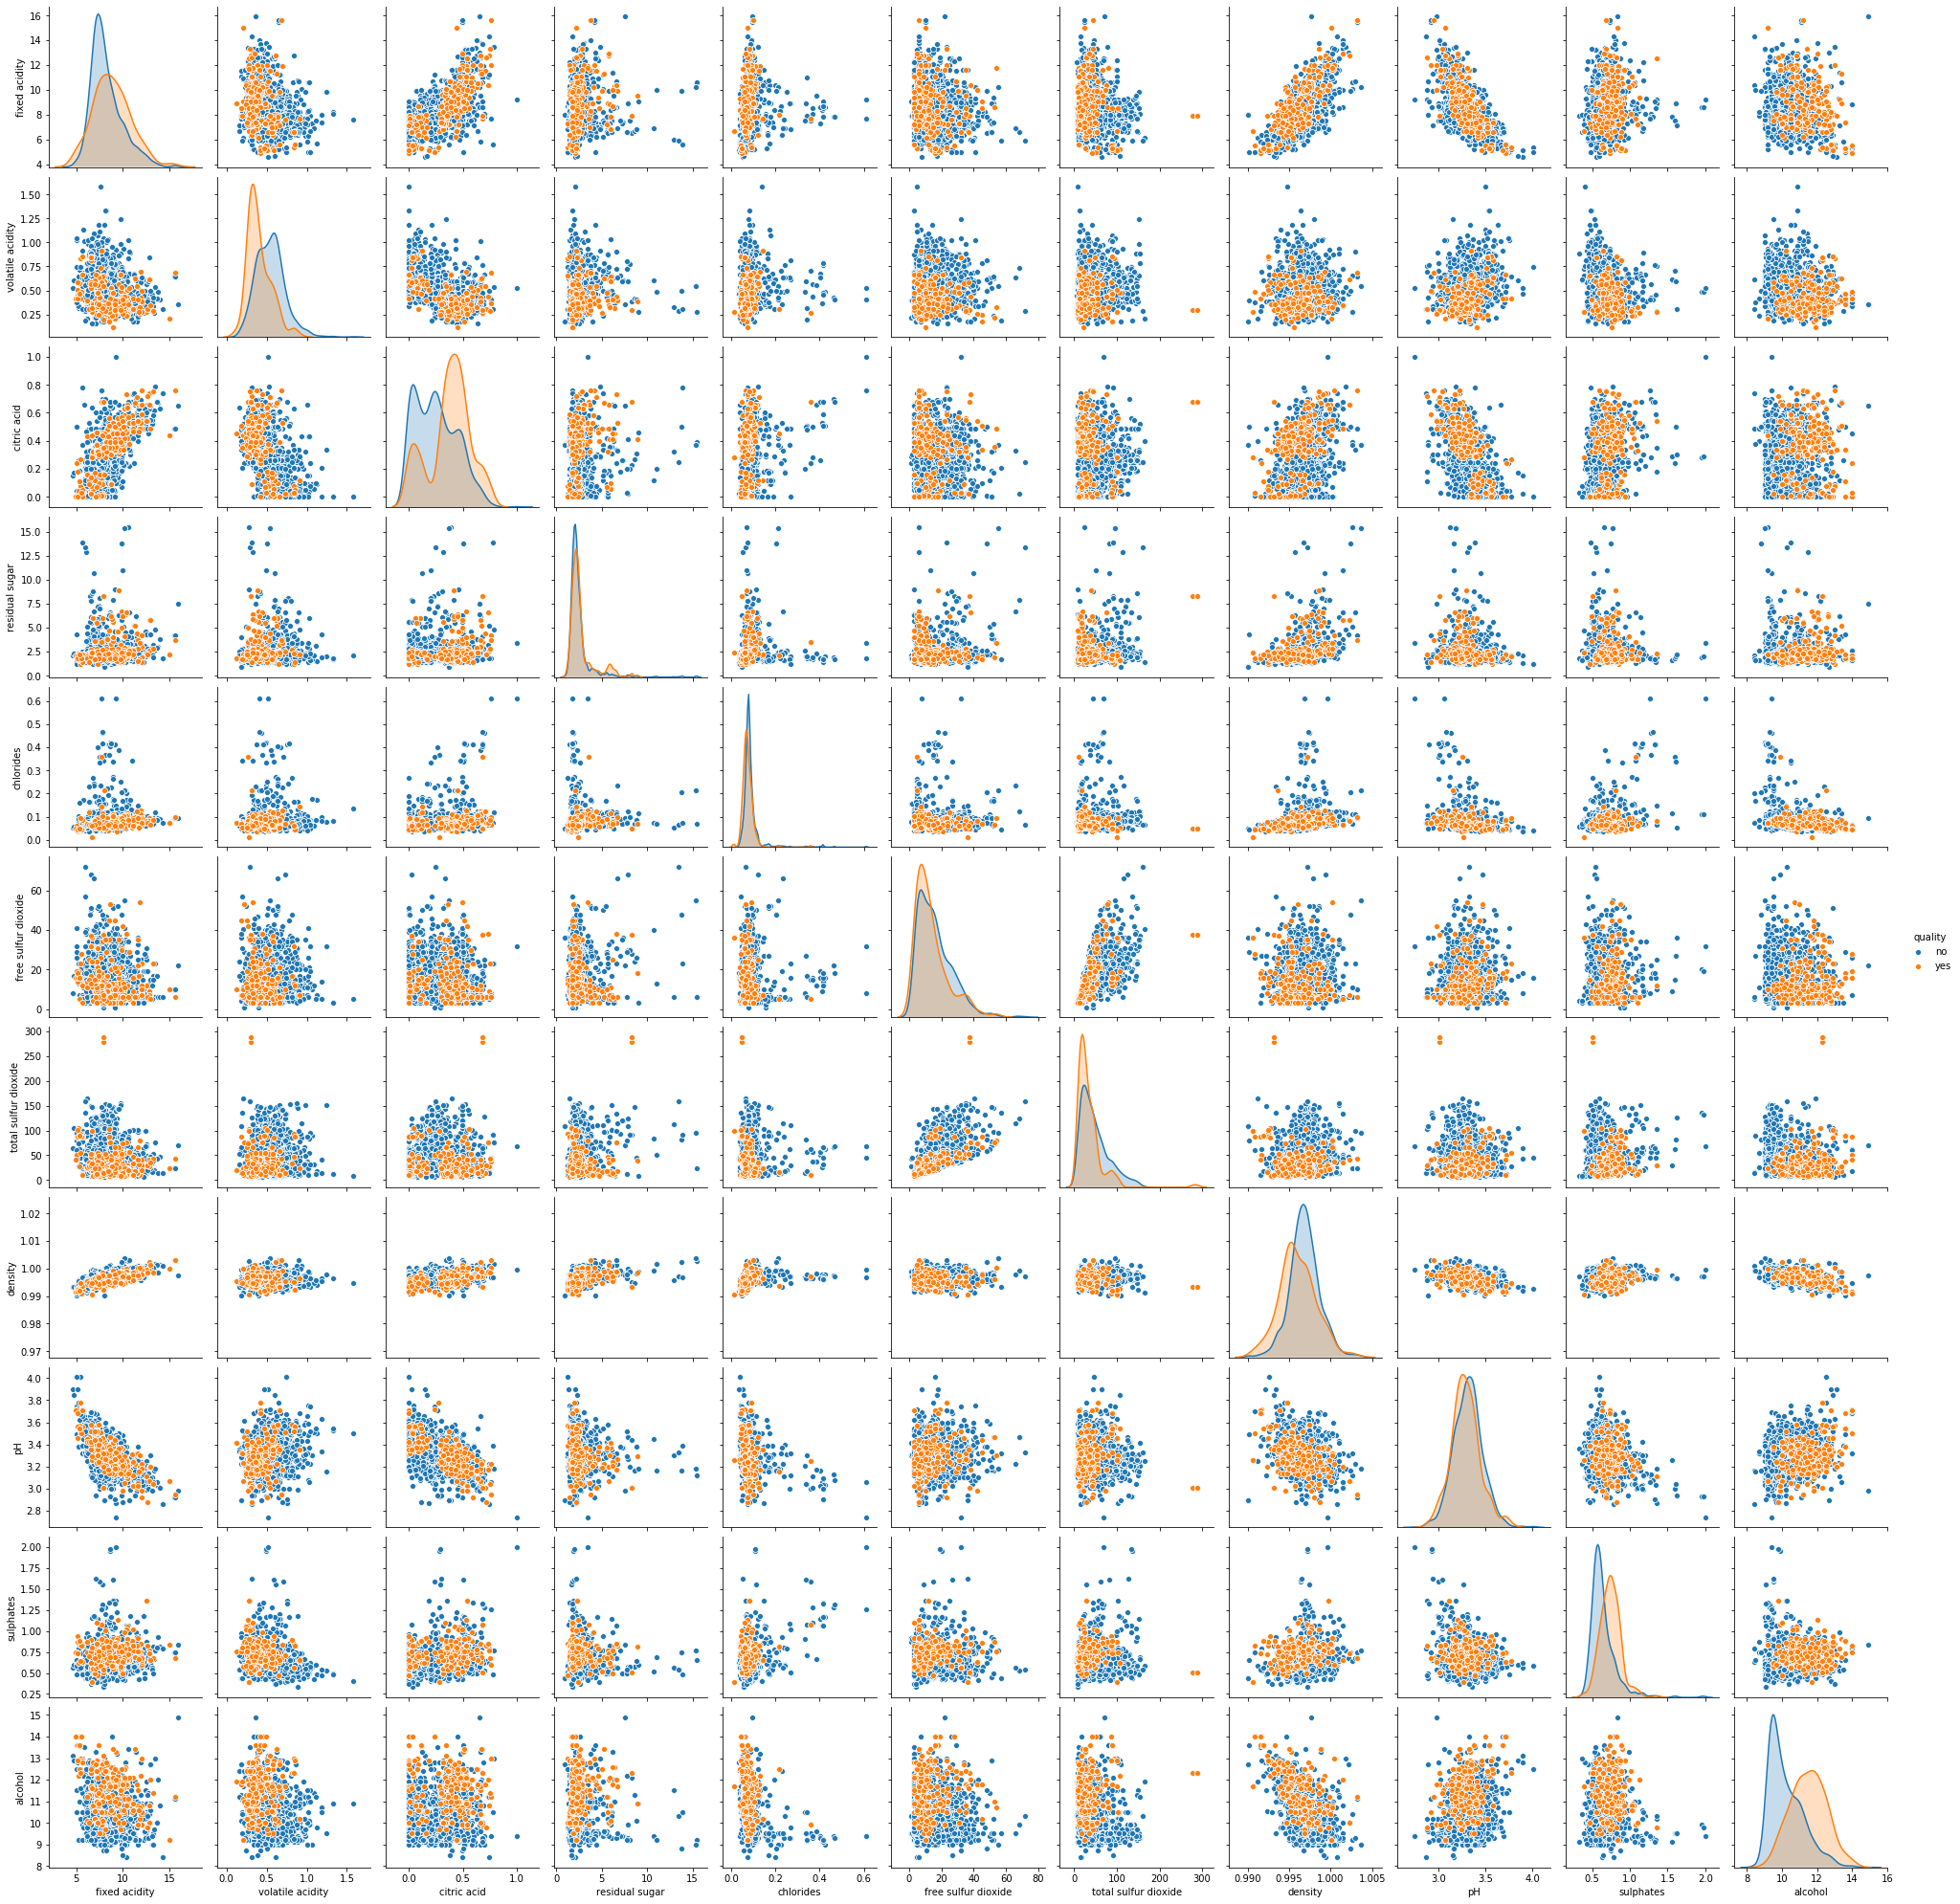

In [2]:
sns.pairplot(wine,hue="quality")

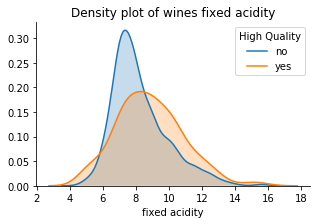

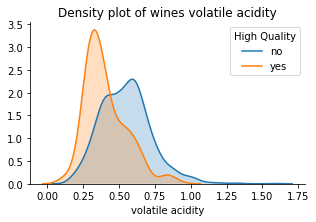

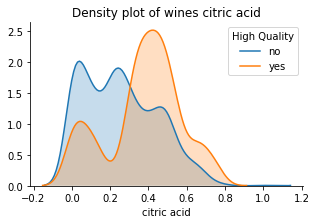

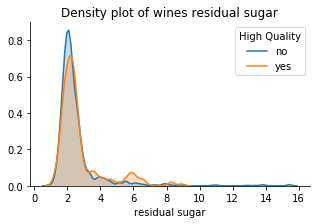

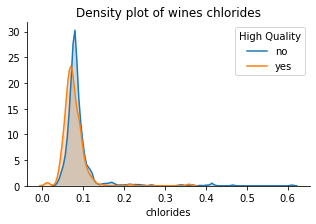

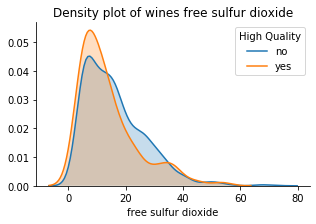

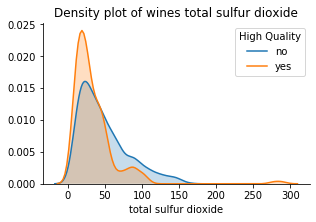

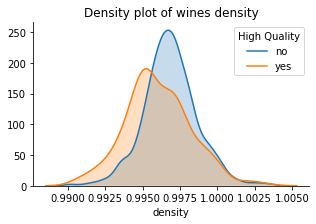

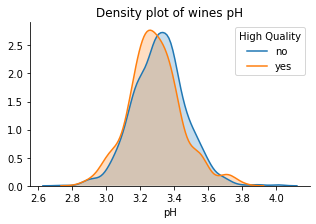

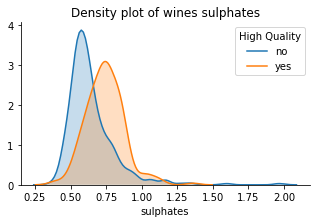

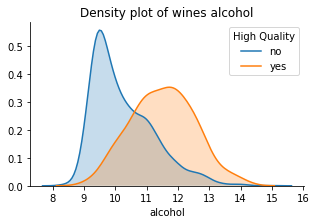

In [3]:
def make_distplot(df,colname,ratio=1):
    fct = sns.FacetGrid(df, hue = 'quality',aspect=ratio)
    return fct.map(sns.distplot, colname, hist=False, kde=True,kde_kws = {'shade': True, 'linewidth': 1.5})

for column in wine.columns[0:11]:
    make_distplot(wine,column,ratio=1.5)
    plt.legend(title="High Quality")
    plt.title(f'Density plot of wines {column}')

## SMOTE

- The proportion of high-quality vs normal-quality wines is highly imbalanced. I use the oversampling technique SMOTE to create a *training* dataset that is resampled to have an equal proportion of both classes.
- Any variable transformation / standardization will take place after the training/testing set split to ensure data leakage does not occur.

In [4]:
# check for imbalanced classes
print(wine.quality.value_counts(),'\n')

print(f'Proportion of high-quality wines: {round(wine.quality.value_counts()["yes"]/wine.quality.count()*100,2)}%')
print(f'Proportion of normal-quality wines: {round(wine.quality.value_counts()["no"]/wine.quality.count()*100,2)}%')
# the classes are highly imbalanced!

# split data into training and test sets; random state for reproducability
from sklearn.model_selection import train_test_split

features = wine.drop('quality',axis=1)
target = wine['quality']
Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                random_state=42, 
                                                stratify=target)

no     1382
yes     217
Name: quality, dtype: int64 

Proportion of high-quality wines: 13.57%
Proportion of normal-quality wines: 86.43%


In [5]:
# use SMOTE to re-sample equally
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(Xtrain,ytrain) # res = resampled

print(y_res.value_counts())
# now the classes are equally represented

yes    1036
no     1036
Name: quality, dtype: int64


## Data Wrangling

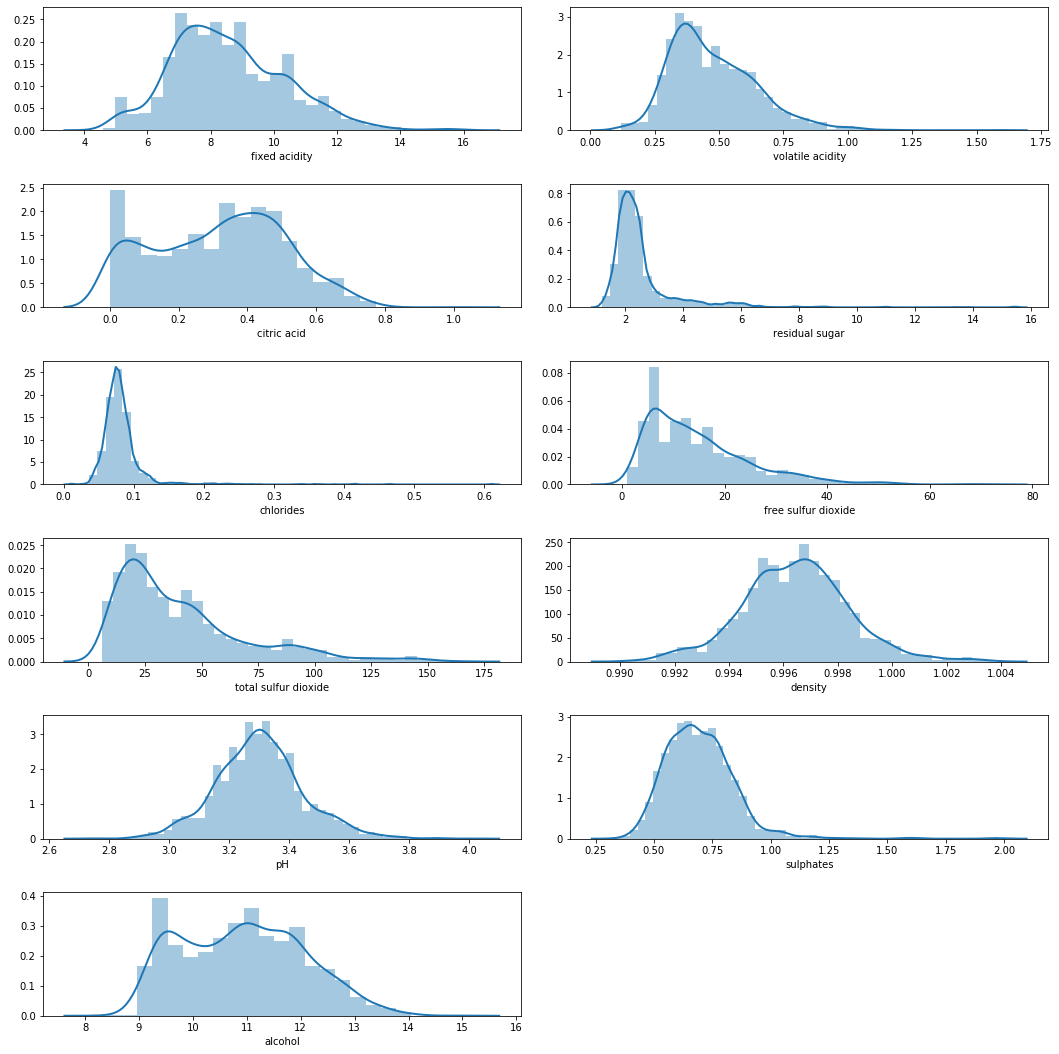

In [6]:
# check distributions to see which ones to transform
fig = plt.figure(figsize=(15,15))
for index,column in enumerate(list(X_res.columns)):
    plt.subplot(6,2,index+1)
    sns.distplot(X_res.loc[:, column], kde_kws={"lw":2})
#     sns.distplot(X_res.loc[:, column], hist_kws={"color":"r"}, kde_kws={"color":"b", "lw":2})
fig.tight_layout(pad = 2)

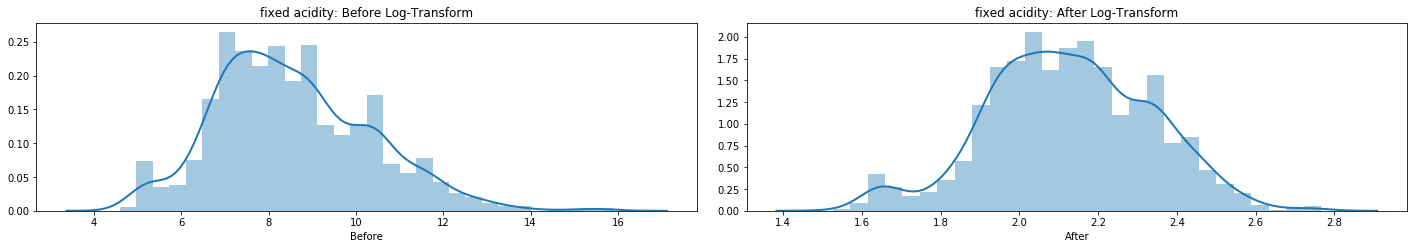

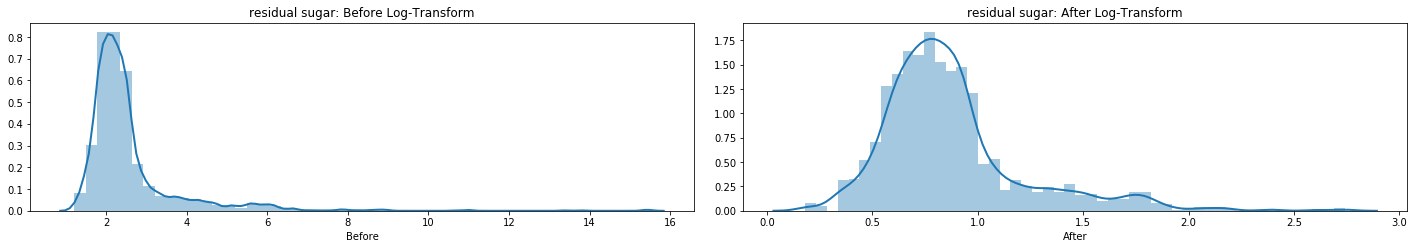

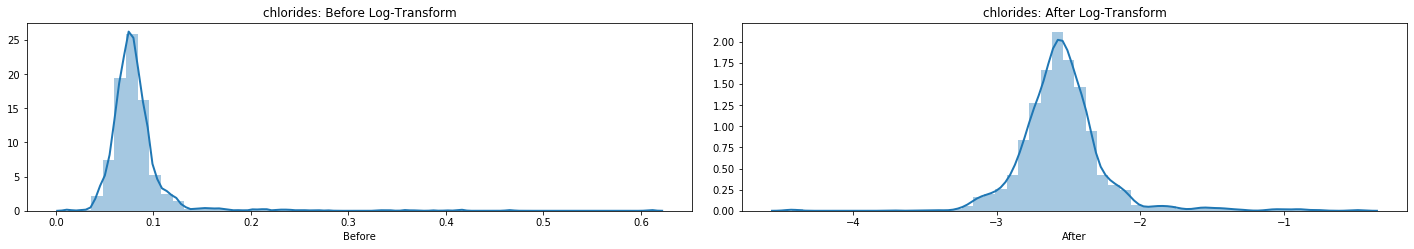

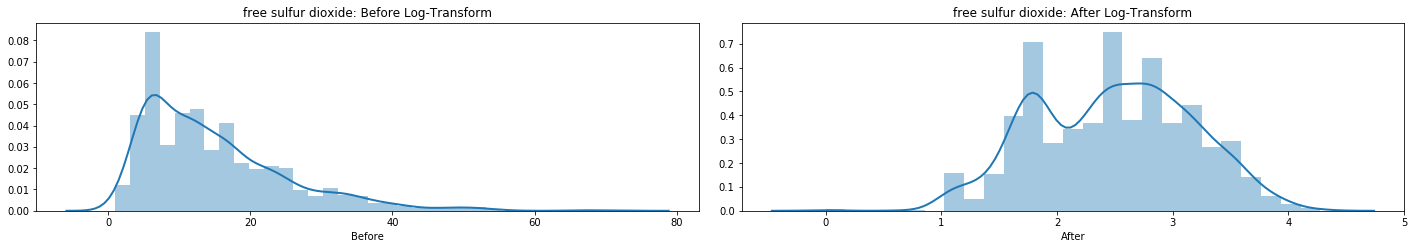

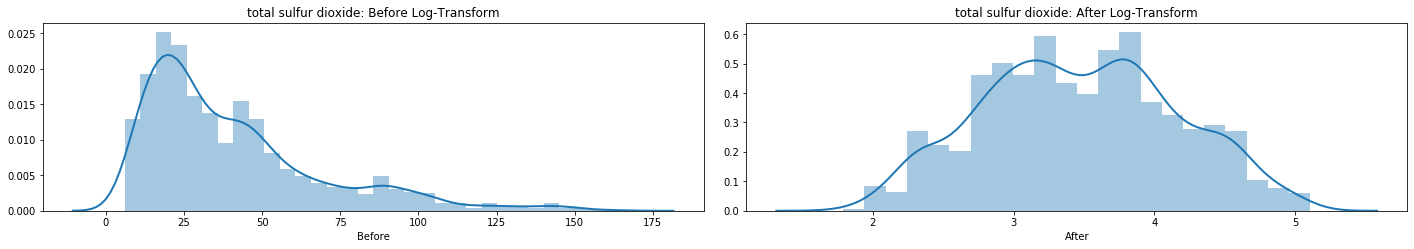

In [7]:
# Plotting function to visualize log transform
def log_transform_col(data,column_name):
    df = pd.DataFrame({'Before':data[column_name],
                      'After':np.log(data[column_name])})
    
    fig = plt.figure(figsize=(20,20))
    for index,column in enumerate(list(df.columns)):
        plt.subplot(6,2,index+1)
        plt.title(f'{column_name}: {column} Log-Transform')
        sns.distplot(df.loc[:, column], kde_kws={"lw":2})
        fig.tight_layout(pad = 2)
        
log_transform_col(X_res,'fixed acidity')
log_transform_col(X_res,'residual sugar')
log_transform_col(X_res,'chlorides')
log_transform_col(X_res,'free sulfur dioxide')
log_transform_col(X_res,'total sulfur dioxide')

In [9]:
def TransformVariables(train_X, test_X):
    df_train, df_test = train_X.copy(), test_X.copy()
    columns = ['fixed acidity','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide']
    for col in columns:
        df_train[col] = np.log(df_train[col])
        df_test[col] = np.log(df_test[col])
    
    return(df_train,df_test)

X_res, Xtest = TransformVariables(X_res, Xtest)

In [15]:
wine_temp = pd.concat((X_res,y_res),axis=1)

In [24]:
X_res

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,2.104134,0.635000,0.100000,0.741937,-2.617296,3.218876,4.094345,0.996380,3.290000,0.750000,10.900000
1,1.902108,0.320000,0.440000,0.875469,-2.796881,3.178054,3.526361,0.994840,3.290000,0.800000,11.600000
2,2.341806,0.440000,0.420000,0.405465,-1.931022,3.526361,3.871201,0.998320,3.380000,0.860000,9.900000
3,2.079442,0.450000,0.230000,0.788457,-2.364460,2.772589,3.367296,0.996200,3.210000,0.490000,10.200000
4,2.476538,0.380000,0.510000,0.693147,-2.111965,1.945910,2.995732,0.999600,3.240000,0.760000,10.400000
...,...,...,...,...,...,...,...,...,...,...,...
2067,2.021473,0.420759,0.332472,0.756675,-2.853627,3.473430,3.983193,0.996569,3.290646,0.762245,10.748301
2068,2.140220,0.416681,0.189345,0.916291,-2.478759,2.912920,3.875468,0.996940,3.363843,0.828210,10.878165
2069,2.406945,0.310000,0.530000,0.788457,-2.813411,1.098612,2.302585,0.995720,3.020000,0.830000,10.900000
2070,2.308602,0.475456,0.596035,0.793707,-2.346591,1.842775,2.728770,0.996458,3.127684,0.669421,12.019823


# Modeling

In [17]:
# load in all packages
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
def EvaluateModel(model, train_X, test_X, train_y, test_y):
    model.fit(train_X,train_y)
    print(model)
    print(f'Train set accuracy: {model.score(train_X,train_y)}%')
    print(f'Test set accuracy: {model.score(test_X,test_y)}%')
    print('Confusion Matrix:','\n', confusion_matrix(test_y, model.predict(test_X)))
    print('Classification Report:','\n', classification_report(test_y, model.predict(test_X)))

## KNN Classifier

## Random Forest

In [40]:
# out of box random forest
rfc = RandomForestClassifier(random_state=42)
EvaluateModel(rfc,X_res,Xtest,y_res,ytest)

RandomForestClassifier(random_state=42)
Train set accuracy: 1.0%
Test set accuracy: 0.9025%
Confusion Matrix: 
 [[323  23]
 [ 16  38]]
Classification Report: 
               precision    recall  f1-score   support

          no       0.95      0.93      0.94       346
         yes       0.62      0.70      0.66        54

    accuracy                           0.90       400
   macro avg       0.79      0.82      0.80       400
weighted avg       0.91      0.90      0.90       400



In [45]:
#max_depth
rf = RandomForestClassifier(random_state=42,max_features="sqrt")

In [55]:
GridSearchCV?

In [ ]:
params = {'max_features': ["sqrt",5],
          'min_samples_split': [25,50,100],
          'n_estimators': [50,100,300,500]}

rfc_grid = GridSearchCV(rf,params,return_train_score=True,scoring='f1')
rfc_grid.fit(X_res,y_res)
results = pd.DataFrame(rfc_grid.cv_results_)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/Applica

In [ ]:
results[['param_max_features','param_min_samples_split','param_n_estimators',
         'mean_test_score','mean_train_score','rank_test_score']].sort_values('rank_test_score')

## Linear SVC

In [ ]:
rfc = RandomForestClassifier(max_depth=4, max_features='sqrt', min_samples_split=100,class_weight='balanced',
                             n_estimators=250)
rfc.fit(Xtrain,ytrain)

print(f'Training accuracy: {rfc.score(Xtrain,ytrain)}')
print(f'Test accuracy: {rfc.score(xtest,ytest)}')

print(confusion_matrix(ytest,rfc.predict(xtest)))

print(classification_report(ytest,rfc.predict(xtest)))